In [ ]:
# Ref:
# https://medium.com/@drcjudelhi/bert-fine-tuning-on-quora-question-pairs-b48277787285
# https://github.com/google-research/bert
# https://www.youtube.com/watch?v=hOCDJyZ6quA
# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
# https://iq.opengenus.org/sentence-semantic-similarity-bert/
# https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/47_BERT_text_classification/BERT_email_classification-handle-imbalance.ipynb


# Function / Class

In [ ]:
import pandas as pd
import re

def clean(sentence, max_len= 40):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # removing contractions
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "what is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"'bout", "about", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  # remove extra spaces  " hi     man  " --> " hi man "
  sentence = re.sub(' +', ' ', sentence)
  sentence = sentence.strip()
  sentence = ' '.join(sentence.split(' ')[:max_len])
  return sentence



In [ ]:
%%capture
!gdown --id '1-Cd08MsOZkrKC9T9-3HkYMCgO3V2OeBX' # train.csv

In [ ]:
%%capture
!gdown --id '1-9IZqER_mDaxvYX8sLpIPVuVcyMnDwjO' # valid.csv

In [ ]:
%%capture
!gdown --id '1-PZh0IZWpcNdruG4CUWCVgvrvH9pP_Qo' # test.csv

In [ ]:
%%capture
!gdown --id '1-RITueazPHbY7D25AeUld4J0FneDY1DH' # SearchSpace.txt

In [ ]:
# %%capture
# !gdown --id '16XEt9yBjigJp39q17GPxPJRCe2ThyTW0' #SMSSpamCollection.txt 
# needed for test purpose

In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')
dev_df = pd.read_csv('valid.csv')
holdout_df = pd.read_csv('test.csv')
search_space = []
with open('SearchSpace.txt') as f:
    search_space = [clean(line) for line in f]


In [ ]:
train_df.shape, dev_df.shape, holdout_df.shape

((152104, 3), (14138, 3), (13480, 3))

In [ ]:
train_df.head(2)

,Input,Output,Label
0,I'd like to start by talking about prices .,I'd be glad to answer any questions you may h...,1
1,Why ? Isn't it obvious ? First you impose way...,"I'm very sorry for that , but I sent you seve...",1


In [ ]:
holdout_df.head(2)

,Input,Output,Label
0,I know . I wonder what's keeping him .,Here are your keys . I ’ ll send my sister to...,0
1,I think my arm is broken .,"Sorry about your arm , but it serves you righ...",1


In [ ]:
# train_df.iloc[152099]["Input"] \
# , train_df.iloc[152099]["Output"] \
# , train_df.iloc[152099]["Label"]

# ('Hello , sir . Can I help you ? ',
#  " that'd be great ! I know he'd appreciate your help . ",
#  0)

# # Corollary => Dataset is utterly noisy!

# train_df['Label'].mean(),dev_df['Label'].mean(),holdout_df['Label'].mean()
# >> (0.5, 0.5, 0.5)
# # Corrolary -> all datasets are balanced

In [ ]:
# train_df.keys()
# >> Index(['Input', 'Output', 'Label'], dtype='object')


# Question 1

In [ ]:
%%capture
!pip install transformers

In [ ]:
from transformers.utils.dummy_pt_objects import BartForCausalLM
t_questions = []
t_answers = []
t_labels = []

max_records = 10000000000
i = 0
for index, row in train_df.iterrows():
    i += 1
    t_questions.append(clean(row['Input']))
    t_answers.append(clean(row['Output']))
    t_labels.append(row['Label'])
    if i == max_records: 
      i = 0
      break
    

d_questions = []
d_answers = []
d_labels = []

for index, row in dev_df.iterrows():
    i += 1
    d_questions.append(clean(row['Input']))
    d_answers.append(clean(row['Output']))
    d_labels.append(row['Label'])
    if i == max_records: 
      i = 0
      break

h_questions = []
h_answers = []
h_labels = []

for index, row in holdout_df.iterrows():
    i +=1
    h_questions.append(clean(row['Input']))
    h_answers.append(clean(row['Output']))
    h_labels.append(row['Label'])
    if i == max_records: 
      i = 0
      break

for i in range(len(search_space)):
  search_space[i] = clean(search_space[i])


In [ ]:
search_space[:5]

['yes . it was sunny and warm yesterday but the wind is really blowing hard now .',
 'did you like them ? you could take the last one home with you .',
 'nowadays , they offer so many services , you hardly know which one to choose . take mailing for example . do you send something first class or second class or do you use ems ?',
 'thank you . i have got quite clear idea of it .',
 'definitely . that is why many cross cultural marriages end in divorce .']

In [ ]:
t_questions[0], t_answers[0], t_labels[0] , len(t_questions) \
,len(d_questions) , len(h_questions)

('i would like to start by talking about prices .',
 'i would be glad to answer any questions you may have .',
 1,
 152104,
 14138,
 13480)

In [ ]:
max([len(x.split(" ")) for x in t_questions]) \
, max([len(x.split(" ")) for x in d_questions]) \
, max([len(x.split(" ")) for x in h_questions]) 

(40, 40, 40)

In [ ]:
from tensorflow.keras.utils import to_categorical

t_labels = to_categorical(t_labels)
d_labels = to_categorical(d_labels)
h_labels = to_categorical(h_labels)

In [ ]:
type(t_labels)

numpy.ndarray

In [ ]:
from transformers import BertTokenizer
import numpy as np
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# TOkenizing t,d,h

In [ ]:
t_input_ids=[]
t_attention_masks=[]

for i in range(len(t_questions)):
    bert_inp = bert_tokenizer.encode_plus(t_questions[i],t_answers[i],
                                        add_special_tokens = True,
                                        max_length =100,
                                        pad_to_max_length = True, 
                                        return_attention_mask = True)
    
    t_input_ids.append(bert_inp['input_ids'])
    t_attention_masks.append(bert_inp['attention_mask'])

t_input_ids = np.asarray(t_input_ids)
t_attention_masks = np.array(t_attention_masks)
# t_labels = np.array(t_labels)

In [ ]:
d_input_ids=[]
d_attention_masks=[]

for i in range(len(d_questions)):
    bert_inp = bert_tokenizer.encode_plus(d_questions[i],d_answers[i],
                                        add_special_tokens = True,
                                        max_length =100,
                                        pad_to_max_length = True, 
                                        return_attention_mask = True)
    
    d_input_ids.append(bert_inp['input_ids'])
    d_attention_masks.append(bert_inp['attention_mask'])

d_input_ids = np.asarray(d_input_ids)
d_attention_masks = np.array(d_attention_masks)
# t_labels = np.array(t_labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
  h_input_ids=[]
  h_attention_masks=[]

  for i in range(len(h_questions)):
      bert_inp = bert_tokenizer.encode_plus(h_questions[i],h_answers[i],
                                          add_special_tokens = True,
                                          max_length =100,
                                          pad_to_max_length = True, 
                                          return_attention_mask = True)
      
      h_input_ids.append(bert_inp['input_ids'])
      h_attention_masks.append(bert_inp['attention_mask'])

  h_input_ids = np.asarray(h_input_ids)
  h_attention_masks = np.array(h_attention_masks)
# t_labels = np.array(t_labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Defining the model

In [ ]:
import tensorflow as tf
from transformers import TFBertModel, TFBertForPreTraining

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
import matplotlib.pyplot as plt
#!pip install IPython
from IPython.display import clear_output as cls

class PlotLosses(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.i = 0
    self.x = []
    self.losses= []
    self.val_losses = []
    self.fig = plt.figure()
    self.logs = []

    self.accuracy = []
    self.val_accuracy = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))    
    self.i +=1
    self.accuracy.append(logs.get('accuracy'))
    self.val_accuracy.append(logs.get('val_accuracy'))

    cls(wait=True)
    plt.plot(self.x, self.losses, label= 'loss')
    plt.plot(self.x, self.val_losses, label= 'val_loss')
    plt.legend()
    plt.show()

    plt.plot(self.x, self.accuracy, label= 'accuracy')
    plt.plot(self.x, self.val_accuracy, label= 'val_accuracy')
    plt.legend()
    plt.show()



In [ ]:
  plot_losses = PlotLosses()

  # save my model based on "val_accuracy" ! 
  # mode='max' !

  checkpoint = ModelCheckpoint('/kickass_bert-{epoch:03d}--{val_accuracy:03f}.h5',
                              verbose=1, monitor='val_accuracy',save_best_only=True,
                              save_weights_only=True, mode='max')


In [ ]:
SEQ_LEN = 100

bert = TFBertModel.from_pretrained('bert-base-uncased')

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[1]
# X = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(embeddings)
X = embeddings
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X)

bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

bert_model.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

# Training the model

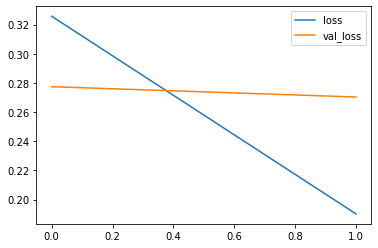

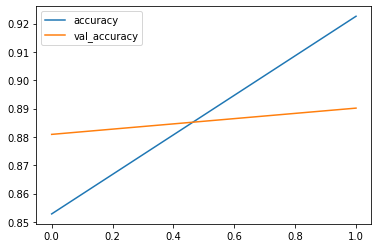

4754/4754 [==============================] - 3100s 652ms/step - loss: 0.1902 - accuracy: 0.9226 - val_loss: 0.2703 - val_accuracy: 0.8902


In [ ]:
history = bert_model.fit([t_input_ids, t_attention_masks], t_labels,
                       batch_size = 32,
                       epochs = 2,
                       validation_data = ([d_input_ids, d_attention_masks],d_labels),
                       callbacks= [checkpoint,plot_losses])


In [ ]:
# # save my model:
# %cp 'kickass_bert--epoch--2--val_accuracy--0.8902.h5' '/content/drive/MyDrive/chatBot_momtazi/data/7'

# Load the best model

In [ ]:
!pip install --upgrade --no-cache-dir gdown


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=afb6df1a1452c9af9d7066dc511a22060e6344e11c1be2106f7cfcfe1f0d854d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ks_d4nkm/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [ ]:
!gdown --id '1UhnmswkdAyJkwEOpica6ybigMiC5p0xV'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1UhnmswkdAyJkwEOpica6ybigMiC5p0xV
To: /content/kickass_bert--epoch--2--val_accuracy--0.8902.h5
100% 438M/438M [00:03<00:00, 111MB/s]


In [ ]:
# load the best model:
best_model_path = 'kickass_bert--epoch--2--val_accuracy--0.8902.h5'
bert_model.load_weights(best_model_path)

In [ ]:
# bert_model.evaluate([h_input_ids, h_attention_masks], h_labels)

# Evaluate

In [ ]:
h_predict = bert_model.predict([h_input_ids, h_attention_masks])

In [ ]:
h_predict[:5]

array([[9.9998534e-01, 1.4659347e-05],
       [3.9361034e-06, 9.9999607e-01],
       [1.5254888e-05, 9.9998474e-01],
       [5.4819500e-01, 4.5180497e-01],
       [3.0249057e-04, 9.9969757e-01]], dtype=float32)

In [ ]:
import math

In [ ]:
y_predicted = [round(x[1]) for x in h_predict]
y_test = [round(x[1]) for x in h_labels]
# y_predicted


In [ ]:
y_predicted[:5]

[0, 1, 1, 0, 1]

In [ ]:
h_labels[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[5862,  878],
       [ 539, 6201]])

Text(33.0, 0.5, 'Truth')

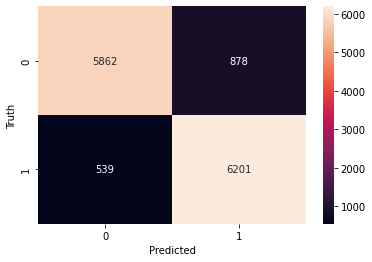

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.92      0.87      0.89      6740
           1       0.88      0.92      0.90      6740

    accuracy                           0.89     13480
   macro avg       0.90      0.89      0.89     13480
weighted avg       0.90      0.89      0.89     13480



In [ ]:
# Based on trial and error, I chose the threashold to be 0.5 and 
# I used one dence layer 

# Q2

In [ ]:
q2_que = [
          'enter your text:what do you do for your weekend ?',
          'sir you look so silly',
          'I am going to visit my friends now',
          'how about you asking me a question . ask me the most difficult question that you know',
          'so it seems you are always not sure',
]

q2_ans = [
          'i am very much .',
          'i am very much .',
          'i am not sure .',
          'i am very much .',
          'i am very much .',       
]


In [ ]:
def question2handler():
  q2_input_ids=[]
  q2_attention_masks=[]

  for i in range(len(q2_que)):
      bert_inp = bert_tokenizer.encode_plus(q2_que[i],q2_ans[i],
                                          add_special_tokens = True,
                                          max_length =100,
                                          pad_to_max_length = True, 
                                          return_attention_mask = True)
      
      q2_input_ids.append(bert_inp['input_ids'])
      q2_attention_masks.append(bert_inp['attention_mask'])

  q2_input_ids = np.asarray(q2_input_ids)
  q2_attention_masks = np.array(q2_attention_masks)  

  q2_predict = bert_model.predict([q2_input_ids, q2_attention_masks])

  print('\n\n')
  for i in range(len(q2_ans)):
    print(q2_que[i],'\n',q2_ans[i])
    status = "IsNext." if q2_predict[i][1] >0.5 else "NotNext."
    print(status,'\n\n')


In [ ]:
question2handler()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,





enter your text:what do you do for your weekend ? 
 i am very much .
NotNext. 


sir you look so silly 
 i am very much .
IsNext. 


I am going to visit my friends now 
 i am not sure .
NotNext. 


how about you asking me a question . ask me the most difficult question that you know 
 i am very much .
NotNext. 


so it seems you are always not sure 
 i am very much .
IsNext. 




Further Analysis!

**All in all, Bert is doing pretty good.**

1. Bert has correctly predicted the first pair. The first pair is obviously irrelevent.
2. Bert has correctly predicted the second pair. The second pair's sentences are grammatically and semantically related.
3. Bert has correctly predicted the third pair. They are not semantically relevent.
4. Bert has correctly predicted the fourth pair. They are not semantically relevent.
5. Bert has correctly predicted the fifth pair. They are relevent, yet not totally grammatically inline.



# Q3

In [ ]:
q3_que = [
          "how are you?",
          "what do you want to eat?",
          "what is your favorite color?",
          "what is your favorite color?",
          "Where have you been?",
          "Do you consider yourself a good mother?",
          "I have two nice sisters.",
]

q3_ans = [
          "Well, I love going to the cinema.",
          "I want to drink coffee.",
          "study.",
          "pink.",
          "i lived in England when i was at the conference . i always wanted to go out dancing.",
          "Yes , I am a very good mother and successful career woman.",
          "Is he very understanding and supportive?",
          
]

In [ ]:
def question3handler():
  q3_input_ids=[]
  q3_attention_masks=[]

  for i in range(len(q3_que)):
      bert_inp = bert_tokenizer.encode_plus(q3_que[i],q3_ans[i],
                                          add_special_tokens = True,
                                          max_length =100,
                                          pad_to_max_length = True, 
                                          return_attention_mask = True)
      
      q3_input_ids.append(bert_inp['input_ids'])
      q3_attention_masks.append(bert_inp['attention_mask'])

  q3_input_ids = np.asarray(q3_input_ids)
  q3_attention_masks = np.array(q3_attention_masks)  

  q3_predict = bert_model.predict([q3_input_ids, q3_attention_masks])
  print('\n\n')
  for i in range(len(q3_ans)):
    print(q3_que[i],'\n',q3_ans[i])
    status = "IsNext." if q3_predict[i][1] >0.5 else "NotNext."
    print(status,'\n\n')

In [ ]:
question3handler()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,





how are you? 
 Well, I love going to the cinema.
NotNext. 


what do you want to eat? 
 I want to drink coffee.
IsNext. 


what is your favorite color? 
 study.
NotNext. 


what is your favorite color? 
 pink.
IsNext. 


Where have you been? 
 i lived in England when i was at the conference . i always wanted to go out dancing.
IsNext. 


Do you consider yourself a good mother? 
 Yes , I am a very good mother and successful career woman.
IsNext. 


I have two nice sisters. 
 Is he very understanding and supportive?
NotNext. 




Further Analysis!

**All in all, Bert is doing pretty good.**

1. Bert has correctly predicted the first pair.
2. Bert has almost correctly predicted the second pair. We can use both 'eat' and 'drink' for soup or some foods, but I am pretty sure that we can't use 'eat' for 'coffee'; so, the model has a booboo here.
3. Bert has correctly predicted the third pair.
4. Bert has correctly predicted the fourth pair. 
5. Bert has correctly predicted the fifth pair. The first part is relevent but the second part is not GENERALLY germane to any conversation. So, This case could also be "NotNext" in my opinion.
6. Bert has correctly predicted the sixth pair.
7. Bert has correctly predicted the seventh pair.



# Q4

In [ ]:
def question4handler(inp):
  q4_input_ids=[]
  q4_attention_masks=[]

  for i in range(len(search_space)):
      bert_inp = bert_tokenizer.encode_plus(inp,search_space[i],
                                          add_special_tokens = True,
                                          max_length =100,
                                          pad_to_max_length = True, 
                                          return_attention_mask = True)
      
      q4_input_ids.append(bert_inp['input_ids'])
      q4_attention_masks.append(bert_inp['attention_mask'])

  q4_input_ids = np.asarray(q4_input_ids)
  q4_attention_masks = np.array(q4_attention_masks)  

  q4_predict = bert_model.predict([q4_input_ids, q4_attention_masks])
  maximum_sigmoid_score = q4_predict[:,1].max()
  max_num_index = np.where(q4_predict[:,1] == maximum_sigmoid_score)[0][0]
  print('\n\n')
  print(inp,'\nThe best reply:',search_space[max_num_index])
  print(maximum_sigmoid_score,'\n\n')

In [ ]:
question4handler(q3_que[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,





how are you? 
The best reply: pretty good . i ve just had my new poems published .
0.9999956 




In [ ]:
question4handler(q3_que[1])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,





what do you want to eat? 
The best reply: i would like to eat a bowl of dumplings .
0.999998 




In [ ]:
question4handler(q3_que[2])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,





what is your favorite color? 
The best reply: black is not my favorite colour .
0.9999995 




In [ ]:
question4handler(q3_que[3])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,





what is your favorite color? 
The best reply: black is not my favorite colour .
0.9999995 




In [ ]:
question4handler(q3_que[4])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,





Where have you been? 
The best reply: at school , in china . this is my first time to be out of my own country .
0.99999833 




In [ ]:
question4handler(q3_que[5])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,





Do you consider yourself a good mother? 
The best reply: not particularly . i like a girl to be good .
0.99999356 




In [ ]:
question4handler(q3_que[6])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,





I have two nice sisters. 
The best reply: interesting . it must be great having a twin sister . are you best friends , too ?
0.99999917 




Further Analysis!

**All in all, Bert is doing pretty good. There are some slips, however. To fairly evaluate this model, we should manually explore the search space to see whether there are any better answers where the model has failed, case 3,4, and 6.**

1. Bert has correctly retrieved an answer. 
2. Bert has correctly retrieved an answer.
3. Bert has NOT correctly retrieved an answer. It seems that the model cannot understand negations.
4. Bert has NOT correctly retrieved an answer. It seems that the model cannot understand negations.
5. Bert has correctly retrieved an answer. 
6. Bert has NOT correctly retrieved an answer. Although the fist part of the answers is relevent, the second part is not logically connected to the question.
7. Bert has correctly retrieved an answer.
